### Курсовой проект по Теории вероятности и математической статистике

###### Цель проекта: 

на базе датасета по фильмам, снятым за длительный период (https://www.kaggle.com/carolzhangdc/imdb-5000-movie-dataset), и датасета по экономическому положению стран (https://www.ilo.org/global/statistics-and-databases/lang--en/index.htm), проверить гипотезу о наличии связи между параметрами созданных фильмов и текущей экономической ситуацией государства.

In [1]:
import numpy as np
import pandas as pd

pd.options.display.max_columns = 100

In [2]:
data = pd.read_csv('input/movie_metadata.csv')
data.shape

(5043, 28)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
color                        5024 non-null object
director_name                4939 non-null object
num_critic_for_reviews       4993 non-null float64
duration                     5028 non-null float64
director_facebook_likes      4939 non-null float64
actor_3_facebook_likes       5020 non-null float64
actor_2_name                 5030 non-null object
actor_1_facebook_likes       5036 non-null float64
gross                        4159 non-null float64
genres                       5043 non-null object
actor_1_name                 5036 non-null object
movie_title                  5043 non-null object
num_voted_users              5043 non-null int64
cast_total_facebook_likes    5043 non-null int64
actor_3_name                 5020 non-null object
facenumber_in_poster         5030 non-null float64
plot_keywords                4890 non-null object
movie_imdb_link              5043 non-

### Подготовка данных по фильмам
Для получения признаков по жанрам фильмов распарсим значения столбца 'genres' и создадим столбцы, соответствующие названиям жанров. Фильм может одновременно быть в нескольких жанрах.

In [4]:
list_of_genres = []

for i in range(len(data['genres'])):
    s = data['genres'][i].split('|')
    for j in range(len(s)):
        if s[j] not in list_of_genres:
            list_of_genres.append(s[j])
    s.clear()    

In [5]:
list_of_genres_ = np.array(list_of_genres).flatten()
list_of_genres_

array(['Action', 'Adventure', 'Fantasy', 'Sci-Fi', 'Thriller',
       'Documentary', 'Romance', 'Animation', 'Comedy', 'Family',
       'Musical', 'Mystery', 'Western', 'Drama', 'History', 'Sport',
       'Crime', 'Horror', 'War', 'Biography', 'Music', 'Game-Show',
       'Reality-TV', 'News', 'Short', 'Film-Noir'], dtype='<U11')

Данные в столбце 'content_rating' - это прямое указание на возрастную аудиторию. Это система рейтингов Американской киноассоциации (англ. MPAA film rating system) — принятая в США система оценки содержания фильма, введённая Американской киноассоциацией (MPAA). Вместо стобца 'content_rating' для целей анализа сделаем систему dummy-столбцов.

In [6]:
data = pd.get_dummies(data, columns=['content_rating']) 

In [7]:
import warnings
warnings.filterwarnings("ignore")

data_new = pd.concat([data,pd.DataFrame(columns=list_of_genres)])

In [8]:
for j in range(len(list_of_genres)):
    data_new[list_of_genres[j]].fillna(0, inplace=True)

Для целей исследования такие метаданные фильма, как имена актёров, название, цветность, язык не являются существенными. Соответствующие колонки стираются.

In [9]:
data_new.drop(['movie_imdb_link', 'plot_keywords', 'movie_title', 'color', 'director_name', 'actor_2_name', 'actor_1_name', 'actor_3_name', 'language'], axis=1, inplace=True)

Учитывая, что в каждой стране своё значение ВВП, ограничим исследование страной с наибольшим количеством фильмов. 

In [10]:
data_new['country'].value_counts()[:5]

USA        3807
UK          448
France      154
Canada      126
Germany      97
Name: country, dtype: int64

Исследуем выборку по фильмам производства США.

In [11]:
data_USA = data_new.loc[data_new['country'].isin(['USA']), :]

In [12]:
data_USA = data_USA.reset_index(drop=True)

Распарсим столбец жанров 'genres' и заполним полученной информацией столбцы с наименованием жанров (из list_of_genres) в бинарном формате (1 и 0)

In [13]:
for i in range(len(data_USA['genres'])):
    s = data_USA['genres'][i].split('|')
    for j in range(len(s)):
        for k in range(len(list_of_genres)):
            if s[j] == list_of_genres[k]:
                data_USA[list_of_genres[k]][i] = 1
    s.clear()    

Так как страна уже выбрана и жанры уже заполнены в отдельных столбцах, то стираем столбцы 'country' и 'genres', стираем строки, где непонятен год, и переустанавливаем индексы.

In [14]:
data_USA.drop(['country', 'genres'], axis=1, inplace=True)

In [15]:
data_USA = data_USA[data_USA['title_year'].notnull()]

In [16]:
data_USA = data_USA.reset_index(drop=True)

Пропущенные данные заменим усреднёнными данными, предварительно сгруппированными по годам.

In [17]:
column_list = ['actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes', 'aspect_ratio', 'budget', 'duration', 'facenumber_in_poster', 'gross', 'num_critic_for_reviews', 'num_user_for_reviews'] 

In [18]:
for item in column_list:
    list_1 = list(data_USA.loc[data_USA[item].isnull(), :].index)
    mean_list = data_USA.groupby('title_year', as_index=False)[[item]].mean()
    year_list = list(data_USA.loc[data_USA.index.isin(list_1), 'title_year'].values)
    mean_1 = mean_list.loc[mean_list['title_year'].isin(year_list), item].mean()
    data_USA.loc[data_USA.index.isin(list_1), item] = mean_1      

Приведём все данные к одному типу.

In [19]:
for item in list_of_genres:
    data_USA[item] = data_USA[item].astype('float64')

In [20]:
data_USA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3733 entries, 0 to 3732
Data columns (total 60 columns):
Action                       3733 non-null float64
Adventure                    3733 non-null float64
Animation                    3733 non-null float64
Biography                    3733 non-null float64
Comedy                       3733 non-null float64
Crime                        3733 non-null float64
Documentary                  3733 non-null float64
Drama                        3733 non-null float64
Family                       3733 non-null float64
Fantasy                      3733 non-null float64
Film-Noir                    3733 non-null float64
Game-Show                    3733 non-null float64
History                      3733 non-null float64
Horror                       3733 non-null float64
Music                        3733 non-null float64
Musical                      3733 non-null float64
Mystery                      3733 non-null float64
News                      

### Подготовка данных по экономике (ВВП)
С сайта International Labour Organization (ILO) берём данные о ВВП (GDP) стран мира.

In [21]:
gdp = pd.read_csv('input/GDP.csv', sep=',', encoding='latin1')
gdp.shape

(264, 64)

Уберём ненужные столбцы.

In [22]:
gdp.drop(['Country Code', 'Indicator Name', 'Indicator Code'], axis=1, inplace=True)

И уберём строки с пропущеным названием страны.

In [23]:
gdp = gdp[gdp['Country Name'].notnull()]

Возьмём данные о ВВП США.

In [24]:
gdp_USA = gdp.loc[gdp['Country Name']=='United States', :].T

Подготовим данные в gdp_USA

In [25]:
gdp_USA.reset_index(inplace=True);

In [26]:
gdp_USA = gdp_USA.rename(columns={'index': 'title_year', 249: 'gdp'});

In [27]:
gdp_USA = gdp_USA.drop([0, 60]);

In [28]:
gdp_USA = gdp_USA.reset_index(drop=True);

Добавим значение в пустую строку и поменяем тип данных датафрейма

In [29]:
gdp_USA.loc[gdp_USA['title_year'] == '2018', 'gdp'] = 2.05134e+13

In [30]:
gdp_USA = gdp_USA.astype('float64')

In [31]:
gdp_USA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 2 columns):
title_year    59 non-null float64
gdp           59 non-null float64
dtypes: float64(2)
memory usage: 1.0 KB


### Итоговый датасет для исследования
Отсортируем датафрейм по фильмам США по годам, переустановим индексы. 

In [32]:
data_USA = data_USA.sort_values(by='title_year')

In [33]:
data_USA = data_USA.reset_index(drop=True)

Произведём слияние датафреймов data_USA и gdp_USA в один датасет по столбцу 'title_year'

In [34]:
film_USA = pd.merge(data_USA, gdp_USA, on='title_year', how='left')

Уберём строки, где отсутствуют данные по ВВП США (в столбце 'gdp') и нулевые столбцы

In [35]:
film_USA = film_USA[film_USA['gdp'].notnull()]

In [36]:
film_USA = film_USA.reset_index(drop=True)

In [37]:
empty_columns = []
film_USA_columns = list(film_USA.columns)
for i in film_USA_columns:
    if film_USA[i].std() == 0 and film_USA[i].mean() == 0:
        empty_columns.append(i)
empty_columns

['Film-Noir',
 'Game-Show',
 'Reality-TV',
 'content_rating_Passed',
 'content_rating_TV-MA',
 'content_rating_TV-Y',
 'content_rating_TV-Y7']

In [38]:
film_USA = film_USA.drop(empty_columns, axis=1)

In [39]:
film_USA.shape

(3664, 54)

### Проведение многомерного статистического анализа
Определение зависимости между признаками. 

Целевой признак ($Y$) - ВВП (столбец 'gdp'),   
остальные признаки составляют матрицу объект-признак ($X$).

In [40]:
feats = list(film_USA.columns)
feats.remove('title_year')
feats.remove('gdp')
feats

['Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Thriller',
 'War',
 'Western',
 'actor_1_facebook_likes',
 'actor_2_facebook_likes',
 'actor_3_facebook_likes',
 'aspect_ratio',
 'budget',
 'cast_total_facebook_likes',
 'content_rating_Approved',
 'content_rating_G',
 'content_rating_GP',
 'content_rating_M',
 'content_rating_NC-17',
 'content_rating_Not Rated',
 'content_rating_PG',
 'content_rating_PG-13',
 'content_rating_R',
 'content_rating_TV-14',
 'content_rating_TV-G',
 'content_rating_TV-PG',
 'content_rating_Unrated',
 'content_rating_X',
 'director_facebook_likes',
 'duration',
 'facenumber_in_poster',
 'gross',
 'imdb_score',
 'movie_facebook_likes',
 'num_critic_for_reviews',
 'num_user_for_reviews',
 'num_voted_users']

In [41]:
X = film_USA[feats].values

In [42]:
Y = film_USA['gdp'].values.reshape(-1, 1)

In [43]:
ones = np.ones((X.shape[0], 1))

In [44]:
X = np.hstack((ones, X))

Проверка ранга матрицы

In [45]:
np.linalg.matrix_rank(X)

53

In [46]:
X.shape[1]

53

In [47]:
XTX = X.T.dot(X)

In [48]:
np.linalg.det(XTX)

1.7042133604363456e+220

In [49]:
XTX_inv = np.linalg.inv(XTX)

Тогда коэффициенты $b_i$ линейного уравнения $Y = b_0 + \displaystyle\sum_{i=1}^n(b_i\cdot x_i) + \varepsilon$, найденные методом наименьших квадратов:

In [50]:
B = XTX_inv.dot(X.T).dot(Y)
B

array([[ 2.31030723e+13],
       [-4.60053070e+11],
       [-6.93719078e+11],
       [ 1.97473252e+12],
       [ 4.16821929e+11],
       [-4.33660668e+11],
       [-5.05260711e+11],
       [ 2.64046114e+12],
       [ 4.73844329e+11],
       [ 1.83325921e+12],
       [-7.94817097e+11],
       [ 2.47396386e+11],
       [-1.28820123e+12],
       [-9.95419529e+09],
       [-8.47396048e+11],
       [ 1.44083477e+11],
       [ 2.40840711e+11],
       [-2.24584814e+11],
       [-1.12210834e+12],
       [-4.33055210e+12],
       [ 3.76833480e+10],
       [-1.25445133e+11],
       [-4.37664182e+11],
       [-1.36960613e+12],
       [-6.50621519e+07],
       [-7.06459403e+07],
       [-9.55008879e+07],
       [ 4.01140766e+11],
       [ 1.20592570e+04],
       [ 7.11758929e+07],
       [-1.21962117e+13],
       [-7.39212258e+12],
       [-1.17869030e+13],
       [-1.16478397e+13],
       [-7.90646391e+12],
       [-2.28053477e+12],
       [-5.77788486e+12],
       [-3.66580988e+12],
       [-4.3

### Оценка полученной модели линейной регрессии

Рассчитаем коэффициент детерминации $R^2$:

In [51]:
Z = X.dot(B)
Z

array([[-4.76912268e+10],
       [ 8.63203845e+12],
       [ 2.27433703e+12],
       ...,
       [ 1.85820560e+13],
       [ 1.64908486e+13],
       [ 1.30794555e+13]])

In [52]:
R2 = Z.var() / Y.var()
R2

0.4790584896859787

Коэффициент детерминации $R^2 = 48 \%$, то есть примерно только половина дисперсии переменной $Y$ объясняется моделью. 

Рассчитаем среднюю ошибку аппроксимации $\overline{A}$:

In [53]:
A = np.abs((Y - Z) / Y).mean()
A

0.39065480384904583

Средняя ошибка аппроксимации $\overline{A} = 39 \% .$    
Данное значение выходит за рамки приемлемых $10 \%$, что означает, что полученная модель линейной регрессии плохо описывает связь между объект-признаком $X$ и целевым признаком $Y$.

Оценим значимость уравнения регрессии с помощью $F$-критерия Фишера

In [54]:
k = X.shape[1]
n = X.shape[0]
k, n

(53, 3664)

In [55]:
k1 = k
k2 = n - k - 1
T = R2/(1 - R2) *(k2/k1)
T

62.63699415227138

Для уровня значимости $\alpha = 0.05$ значение $F_{crit} = F(53, 3610)$:

In [56]:
from scipy import stats
alpha = 0.05

stats.f.ppf(1 - alpha, k1, k2)

1.3432030918496802

Так как статистика $T > F_{crit}$, то уравнение регрессии в целом является статистически значимым.

Попытаемся визуально определить причину высокой средней ошибки аппроксимации и низкого значения коэффициента детерминации.

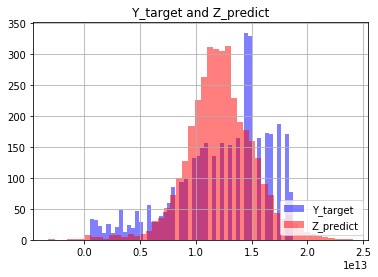

In [58]:
from matplotlib import pyplot as plt

plt.hist(Y, bins=50, color='blue', alpha=0.5, label='Y_target');
plt.hist(Z, bins=50, color='red', alpha=0.5, label='Z_predict');
plt.title('Y_target and Z_predict')
plt.legend(loc='lower right')
plt.grid()

На графике видно, что рассчётные значения целевого признака ($Z$, красного цвета) имеют распределение, близкое к нормальному, а изначальные значения целевой переменной ($Y$, голубого цвета) распределены в виде капли с длинным левым хвостом. По всей видимости не нормальное распределение $Y$ является причиной плохих значений метрик.

### ВЫВОД:
В результате проведённого многомерного статистического анализа данных была подтверждена гипотеза о наличии связи между параметрами созданных фильмов и текущей экономической ситуацией государства. 

Была построена модель линейной регрессии вида $Y = b_0 + \displaystyle\sum_{i=1}^n(b_i\cdot x_i)$ с коэффициентом детерминации $R^2 = 48 \%$ и средней ошибкой аппроксимации $\overline{A} = 39 \% .$ Несмотря на плохие значения $R^2$ и $\overline{A}$, оценка данной модели с помощью $F$-критерия Фишера при $\alpha = 0.05$ показала её статистическую значимость.   

Предположительно, причиной плохой аппроксимации является не нормальное распределение целевой переменной $Y$, что является ограничением для методов корреляционного анализа.   